In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.feature_selection import f_regression, mutual_info_regression 
from sklearn import ensemble

In [4]:
df = pd.read_csv('stationary_data.csv')# read in cleaned data set, stationary years

In [68]:
df.head()

,Year,Month,ZipCode,ZORI,ZHVI,AQI,Population,Unemployment,Percent Bachelors,Units,Total_Households,Med_income,PCE,Rental Vacancy Rate,ZORI_rsq
0,2015,2,10025,3162.0,1171181.0,60.928571,1.623301e+06,5.6,32.2,1126.0,7.304468e+05,72743.449947,1.328401,4.4,0.520441
1,2015,2,60657,1643.0,446997.0,52.785714,5.232495e+06,6.7,22.1,1191.0,1.942356e+06,54319.591794,1.328401,5.4,0.892254
2,2015,2,10023,3229.0,1104524.0,60.928571,1.623301e+06,5.6,32.2,1126.0,7.304468e+05,72743.449947,1.328401,4.4,0.666686
3,2015,2,60614,1808.0,578551.0,52.785714,5.232495e+06,6.7,22.1,1191.0,1.942356e+06,54319.591794,1.328401,5.4,0.906743
4,2015,2,77449,1361.0,151529.0,48.892857,4.299820e+06,4.4,19.0,5938.0,1.511400e+06,53157.359233,1.328401,6.8,0.893101


In [6]:
nallzq = df.ZipCode.unique()

In [7]:
#perform linear fit of ZORI versus year for chosen Zip Code
def zipcodeyrfit(code):
    r1 = LinearRegression()
    y1 = df[df['ZipCode']==code]['ZORI']
    x1 = df[df['ZipCode']==code][['Year']]
    r1.fit(x1, y1)
    return r1.score(x1,y1) 

In [8]:
# determine R2 for all zip codes
ZORI_codes = []
for code in nallzq:
    ZORI_codes.append(zipcodeyrfit(code))

/Applications/anaconda3/envs/Base_new/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Applications/anaconda3/envs/Base_new/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [9]:
code_df = pd.DataFrame({'ZipCode':nallzq, 'ZORI_rsq':ZORI_codes })

<AxesSubplot:>

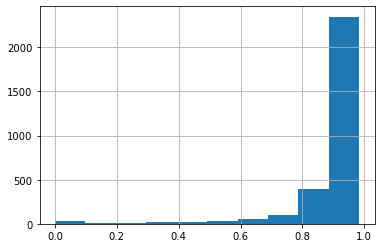

In [11]:
%matplotlib inline
code_df.ZORI_rsq.hist()

In [12]:
df = pd.merge(df, code_df[['ZipCode', 'ZORI_rsq']], left_on = ['ZipCode'],
              right_on = ['ZipCode'], how = 'left')

In [16]:
df = df.fillna(0)
df.isnull().sum(axis=0)

Year                   0
Month                  0
ZipCode                0
ZORI                   0
ZHVI                   0
AQI                    0
Population             0
Unemployment           0
Percent Bachelors      0
Units                  0
Total_Households       0
Med_income             0
PCE                    0
Rental Vacancy Rate    0
ZORI_rsq               0
dtype: int64

In [17]:
# include all data
regression = LinearRegression()
regression.fit(df.iloc[:, 4:], df.iloc[:, 3])
regression.score(df.iloc[:, 4:], df.iloc[:, 3])

0.23528283630126512

In [19]:
# ZORI < 4000
regression = LinearRegression()
regression.fit(df[df['ZORI']<4000].iloc[:, 4:], df[df['ZORI']<4000].iloc[:, 3])
regression.score(df[df['ZORI']<4000].iloc[:, 4:], df[df['ZORI']<4000].iloc[:, 3])

0.7399123217761967

In [20]:
# ZORI_rsq > 0.8
regression = LinearRegression()
regression.fit(df[df['ZORI_rsq']>0.8].iloc[:, 4:], df[df['ZORI_rsq']>0.8].iloc[:, 3])
regression.score(df[df['ZORI_rsq']>0.8].iloc[:, 4:], df[df['ZORI_rsq']>0.8].iloc[:, 3])

0.2875631073159547

In [21]:
# ZORI rsq > 0.8 and ZORI < 4000
regression = LinearRegression()
regression.fit(df[(df['ZORI_rsq']>0.8) & (df['ZORI']<4000)].iloc[:, 4:], 
               df[(df['ZORI_rsq']>0.8) & (df['ZORI']<4000)].iloc[:, 3])
regression.score(df[(df['ZORI_rsq']>0.8) & (df['ZORI']<4000)].iloc[:, 4:], 
               df[(df['ZORI_rsq']>0.8) & (df['ZORI']<4000)].iloc[:, 3])

0.740129923591697

In [61]:
df_change = pd.read_csv('percent_change_data.csv')# read in cleaned data set, percent change

In [62]:
df_change.columns

Index(['Year', 'Month', 'ZipCode', 'ZORI_delta', 'ZHVI_lagged_1_delta',
       'AQI_lagged_1_delta', 'Population_lagged_2_delta',
       'Unemployment_lagged_1_delta', 'Percent Bachelors_lagged_2_delta',
       'Permits_lagged_1_delta', 'Total_Households_lagged_2_delta',
       'Med_Income_lagged_2_delta', 'PCE_lagged_1_delta',
       'Rental Vacancy Rate_lagged_2_delta'],
      dtype='object')

In [27]:
# fit to individual zip code
r1 = LinearRegression()
y1 = df_change[df_change['ZipCode']==10028].iloc[:, 3]
x1 = df_change[df_change['ZipCode']==10028].iloc[:, 4:]
r1.fit(x1, y1)
print(r1.intercept_, r1.coef_, r1.score(x1,y1))

0.16887405933582328 [ 1.36300701e-01  1.17275192e-02  3.94225415e+00 -1.38746677e-03
 -5.90373361e-03  1.68745988e-03  6.41691047e-01 -4.60374484e-01
 -2.38151413e-02 -1.81066875e-02] 0.9586464316712412


In [28]:
change_allzq = df_change.ZipCode.unique()

In [33]:
#perform linear fit of delta ZORI versus year for chosen Zip Code
def zipcodedeltafit(code):
    r1 = LinearRegression()
    y1 = df_change[df_change['ZipCode']==code].iloc[:, 3]
    x1 = df_change[df_change['ZipCode']==code].iloc[:, 4:]
    r1.fit(x1, y1)
    return r1.score(x1,y1) 

In [34]:
# determine R2 for all zip codes
delta_ZORI_codes = []
for code in change_allzq:
    delta_ZORI_codes.append(zipcodedeltafit(code))

In [35]:
delta_code_df = pd.DataFrame({'ZipCode':change_allzq, 'Delta_ZORI_rsq':delta_ZORI_codes })

<AxesSubplot:>

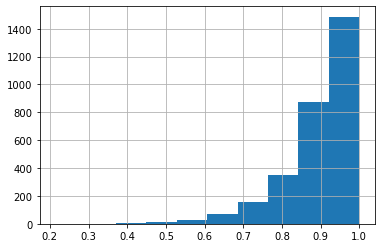

In [36]:
delta_code_df.Delta_ZORI_rsq.hist()

In [63]:
df_change = pd.merge(df_change, delta_code_df[['ZipCode', 'Delta_ZORI_rsq']], left_on = ['ZipCode'],
              right_on = ['ZipCode'], how = 'left')

In [39]:
df_change.columns

Index(['Year', 'Month', 'ZipCode', 'ZORI_delta', 'ZHVI_lagged_1_delta',
       'AQI_lagged_1_delta', 'Population_lagged_2_delta',
       'Unemployment_lagged_1_delta', 'Percent Bachelors_lagged_2_delta',
       'Permits_lagged_1_delta', 'Total_Households_lagged_2_delta',
       'Med_Income_lagged_2_delta', 'PCE_lagged_1_delta',
       'Rental Vacancy Rate_lagged_2_delta', 'Delta_ZORI_rsq'],
      dtype='object')

In [64]:
#include all data
regression = LinearRegression()
regression.fit(df_change.iloc[:, 4:], df_change.iloc[:, 3])
regression.score(df_change.iloc[:, 4:], df_change.iloc[:, 3])

0.20394063742277269

In [65]:
# Delta_ZORI_rsq > 0.8
regression = LinearRegression()
regression.fit(df_change[df_change['Delta_ZORI_rsq']>0.8].iloc[:, 4:], 
               df_change[df_change['Delta_ZORI_rsq']>0.8].iloc[:, 3])
regression.score(df_change[df_change['Delta_ZORI_rsq']>0.8].iloc[:, 4:], 
               df_change[df_change['Delta_ZORI_rsq']>0.8].iloc[:, 3])

0.21238923009502997

In [ ]:
# not much improvment no matter how high cutoff is made.  
# Maybe overfitting occurs for individual zipcodes which doesn't help overall fit

In [45]:
#perform linear fit of ZORI versus year for chosen Zip Code and return slope
def zipcodeyrslope(code):
    r1 = LinearRegression()
    y1 = df[df['ZipCode']==code]['ZORI']
    x1 = df[df['ZipCode']==code][['Year']]
    r1.fit(x1, y1)
    return r1.coef_ 

In [52]:
# determine slope versus time for all zip codes
ZORI_slopes = []
for code in nallzq:
    ZORI_slopes.append(zipcodeyrslope(code))

In [55]:
slope_df = pd.DataFrame({'ZipCode':nallzq, 'Slope_by_year':ZORI_slopes })

<AxesSubplot:>

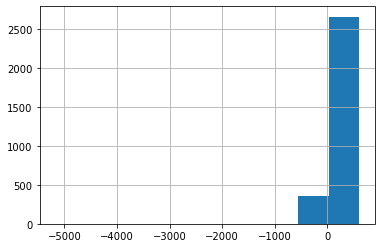

In [56]:
slope_df.Slope_by_year.hist()

In [66]:
#include slope versus year into df_change data frame
df_change = pd.merge(df_change, slope_df[['ZipCode', 'Slope_by_year']], left_on = ['ZipCode'],
              right_on = ['ZipCode'], how = 'left')

In [109]:
#include slope versus year into df data frame
df = pd.merge(df, slope_df[['ZipCode', 'Slope_by_year']], left_on = ['ZipCode'],
              right_on = ['ZipCode'], how = 'left')

In [58]:
df_change.isnull().sum(axis=0)

Year                                  0
Month                                 0
ZipCode                               0
ZORI_delta                            0
ZHVI_lagged_1_delta                   0
AQI_lagged_1_delta                    0
Population_lagged_2_delta             0
Unemployment_lagged_1_delta           0
Percent Bachelors_lagged_2_delta      0
Permits_lagged_1_delta                0
Total_Households_lagged_2_delta       0
Med_Income_lagged_2_delta             0
PCE_lagged_1_delta                    0
Rental Vacancy Rate_lagged_2_delta    0
Delta_ZORI_rsq                        0
Slope_by_year                         0
dtype: int64

In [111]:
df.isnull().sum(axis=0)

Year                   0
Month                  0
ZipCode                0
ZORI                   0
ZHVI                   0
AQI                    0
Population             0
Unemployment           0
Percent Bachelors      0
Units                  0
Total_Households       0
Med_income             0
PCE                    0
Rental Vacancy Rate    0
ZORI_rsq               0
Slope_by_year          0
dtype: int64

In [67]:
#fit including slopes
regression = LinearRegression()
regression.fit(df_change.iloc[:, 4:], df_change.iloc[:, 3])
regression.score(df_change.iloc[:, 4:], df_change.iloc[:, 3])

0.3210707680034721

In [77]:
df_delta = pd.read_csv('time_change_data.csv')

In [80]:
# calculate percent change per year
df_delta['DZORI']=2*(df_delta['ZORI'] - df_delta['ZORI_lagged_1'])/(df_delta['ZORI'] + df_delta['ZORI_lagged_1'])

<AxesSubplot:>

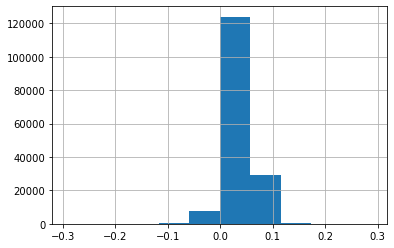

In [90]:
df_delta.DZORI.hist()

 # Comparison of different fitting procedures

In [83]:
#  ZORI > 4000 fitting delta ZORI
regression = LinearRegression()
regression.fit(df_delta[(df_delta['ZORI']<4000)].iloc[:, 5:14], 
               df_delta[(df_delta['ZORI']<4000)].iloc[:, 15])
regression.score(df_delta[(df_delta['ZORI']<4000)].iloc[:, 5:14], 
               df_delta[(df_delta['ZORI']<4000)].iloc[:, 15])

0.10375443998488387

In [95]:
#  ZORI > 4000 fitting ZORI
regression = LinearRegression()
regression.fit(df_delta[(df_delta['ZORI']<4000)].iloc[:, 5:14], 
               df_delta[(df_delta['ZORI']<4000)].iloc[:, 3])
regression.score(df_delta[(df_delta['ZORI']<4000)].iloc[:, 5:14], 
               df_delta[(df_delta['ZORI']<4000)].iloc[:, 3])

0.7359283671804316

In [84]:
randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(random_state=42, n_estimators=100, max_features=2)

RandomForestRegressor(max_features=2, random_state=42)

In [102]:
df_delta.reset_index(inplace = True)
df_delta.drop('index', axis=1, inplace=True)
train_idx = np.random.choice(range(df_delta.shape[0]), round(0.7 * df_delta.shape[0]), replace = False)
test_idx = df_delta.index[~df_delta.index.isin(train_idx)]
train = df_delta.iloc[train_idx, :]
test = df_delta.iloc[test_idx, :]

In [88]:
randomForest.fit(train[(train['ZORI']<4000)].iloc[:, 5:14], 
               train[(train['ZORI']<4000)].iloc[:, 15])

RandomForestRegressor(max_features=2, random_state=42)

In [89]:
#random forest fitting delta ZORI
randomForest.score(test[(test['ZORI']<4000)].iloc[:, 5:14], test[(test['ZORI']<4000)].iloc[:, 15])

0.444692472884898

# Random forest of previous year's features to ZORI

In [103]:
randomForest.fit(train[(train['ZORI']<4000)].iloc[:, 5:14], 
               train[(train['ZORI']<4000)].iloc[:, 3])

RandomForestRegressor(max_features=2, random_state=42)

In [104]:
#fitting ZORI
randomForest.score(test[(test['ZORI']<4000)].iloc[:, 5:14], test[(test['ZORI']<4000)].iloc[:, 3])

0.8509112544398948

In [105]:
randomForest.feature_importances_

array([0.58550185, 0.01654173, 0.06535953, 0.01908829, 0.07225843,
       0.04941294, 0.06483973, 0.11917598, 0.00782151])

In [106]:
fi_values = pd.Series(randomForest.feature_importances_, index = test.iloc[:, 5:14].columns).sort_values()
pd.DataFrame({'feature importance':fi_values})

,feature importance
PCE_lagged_1,0.007822
AQI_lagged_1,0.016542
Unemployment_lagged_1,0.019088
Permits_lagged_1,0.049413
Total_Households_lagged_2,0.064840
Population_lagged_2,0.065360
Percent Bachelors_lagged_2,0.072258
Med_Income_lagged_2,0.119176
ZHVI_lagged_1,0.585502


In [107]:
#fitting without ZHVI
randomForest.fit(train[(train['ZORI']<4000)].iloc[:, 6:14], 
               train[(train['ZORI']<4000)].iloc[:, 3])

RandomForestRegressor(max_features=2, random_state=42)

In [108]:
randomForest.score(test[(test['ZORI']<4000)].iloc[:, 6:14], test[(test['ZORI']<4000)].iloc[:, 3])

0.6635947655275738

In [82]:
df_delta.columns

Index(['Year', 'Month', 'ZipCode', 'ZORI', 'ZORI_lagged_1', 'ZHVI_lagged_1',
       'AQI_lagged_1', 'Population_lagged_2', 'Unemployment_lagged_1',
       'Percent Bachelors_lagged_2', 'Permits_lagged_1',
       'Total_Households_lagged_2', 'Med_Income_lagged_2', 'PCE_lagged_1',
       'Rental Vacancy Rate_lagged_2', 'DZORI'],
      dtype='object')

In [96]:
df_change.columns

Index(['Year', 'Month', 'ZipCode', 'ZORI_delta', 'ZHVI_lagged_1_delta',
       'AQI_lagged_1_delta', 'Population_lagged_2_delta',
       'Unemployment_lagged_1_delta', 'Percent Bachelors_lagged_2_delta',
       'Permits_lagged_1_delta', 'Total_Households_lagged_2_delta',
       'Med_Income_lagged_2_delta', 'PCE_lagged_1_delta',
       'Rental Vacancy Rate_lagged_2_delta', 'Delta_ZORI_rsq',
       'Slope_by_year'],
      dtype='object')

In [97]:
df_change.reset_index(inplace = True)
df_change.drop('index', axis=1, inplace=True)
train_idx = np.random.choice(range(df_change.shape[0]), round(0.7 * df_change.shape[0]), replace = False)
test_idx = df_change.index[~df_change.index.isin(train_idx)]
train = df_change.iloc[train_idx, :]
test = df_change.iloc[test_idx, :]

In [99]:
#random forest fitting percent change in ZORI using percent change in other features
randomForest.fit(train.iloc[:, 4:13], train.iloc[:, 3])

RandomForestRegressor(max_features=2, random_state=42)

In [100]:
randomForest.score(test.iloc[:, 4:13], test.iloc[:, 3])

0.35404114646468177

In [112]:
df.columns

Index(['Year', 'Month', 'ZipCode', 'ZORI', 'ZHVI', 'AQI', 'Population',
       'Unemployment', 'Percent Bachelors', 'Units', 'Total_Households',
       'Med_income', 'PCE', 'Rental Vacancy Rate', 'ZORI_rsq',
       'Slope_by_year'],
      dtype='object')

In [116]:
regression = LinearRegression()
regression.fit(df[(df['ZORI']<4000)].iloc[:, 4:13], 
               df[(df['ZORI']<4000)].iloc[:,15])
regression.score(df[(df['ZORI']<4000)].iloc[:, 4:13], 
               df[(df['ZORI']<4000)].iloc[:, 15])

0.27544407554296135

# Best fit - random forest to slope of ZORI

In [117]:
df.reset_index(inplace = True)
df.drop('index', axis=1, inplace=True)
train_idx = np.random.choice(range(df.shape[0]), round(0.7 * df.shape[0]), replace = False)
test_idx = df.index[~df.index.isin(train_idx)]
train = df.iloc[train_idx, :]
test = df.iloc[test_idx, :]

In [120]:
randomForest.fit(train.iloc[:, 3:13], train.iloc[:, 15])

RandomForestRegressor(max_features=2, random_state=42)

In [121]:
randomForest.score(test.iloc[:, 3:13], test.iloc[:, 15])

0.9440061526305533